# PRACTICE: MNIST
*This is a notebook about classification*

## SETUP

In [15]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "chapter3_classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1. LOOK AT THE BIG PICTURE
*(performance measure, frame the problem, etc.)*

## 2. GET THE DATA

### Dowload the Data

In [6]:
# Fetch data (sklearn)
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

**Evaluate:** Datasets loaded by Sklearn generally have a similiar dictionary structure (`as_frame=False`) including:
- A `DESCR` key describes the dataset
- A `data` key
- A `target` key

### Take a Quick Look at the Data Structure

In [7]:
# Inspect the shape (1)
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [8]:
# Inspect the shape (2)
y.shape

(70000,)

**Evaluate:** There are 70,000 images; each image has 784 features (28x28 pixels)

Saving figure some_digit_plot


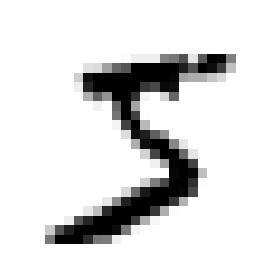

In [9]:
# Take a peek at one digit
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')

save_fig("some_digit_plot")
plt.show()

In [10]:
# What is its label?
y[0]

'5'

**Evaluate:** The label is string, so y will be casted to integers.

In [11]:
# Cast the labels to integers
y = y.astype(np.uint8)

### Create a Test Set

**Evaluate:** The MNIST dataset is already split into a training set (60,000 img) and a test set (10,000 img). (also shuffled)

In [14]:
# Create test and training set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # Numpy array
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## TRAINING A BINARY CLASSIFIER

**Evaluate:** Instead of the identification for digits, the problem is simlified to identify just 1 digit (eg. 5), which is called binary classifier.

In [19]:
# Create the target vectors for 5-classification task
y_train_5 = (y_train == 5) # True for all 5s, False otherwise
y_test_5 = (y_test == 5)

In [20]:
# Train SGD model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [21]:
# Predict whether the former record is the number 5 using SGD model
sgd_clf.predict([some_digit])

array([ True])

**Evaluate:** Guess right!

## PERFORMANCE MEASURES

**Remark:** Evaluating a classifier is often significantly trickier than evaluating a regressor, which is worth pages.

### Measuring Accuracy Using Cross-Validation

In [23]:
# Implementing cross-validation (fuction like cross_val_score() in sklearn)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [24]:
# K-fold cross validation on the model (sklearn)
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

**Evaluate:** Above 90% accuracy on all folds? An insight in "not-5" images is needed.

In [25]:
# Setup a classifier that classifies every image in the "not-5" class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [26]:
# K-fold cross validation on the custom model
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

**Evaluate:** This dumb model has over 90% accuracy. The reason is that only 10% of the images are 5s, which means guessing an image "not-5" will be right about 90% of the time => Accuracy is not preferred measure for classifier (at least with this dataset).

### Confusion Matrix

In [ ]:
# K-fold cross validation on SGD model
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # return preditions made on each test fold

In [33]:
# Inspect the confusion matrix between predictions from cross-validation and the true target
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

**Remark:** By definition a confusion matrix $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. In case of binary classification:

$TN$ | $FP$

$FN$ | $TP$

*(row as actual group; column as predicted group)*

### Precision and Recall

In [34]:
# Compute precision of the model
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [35]:
# Compute recall of the model
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_pred)

0.6511713705958311

**Evaluate:** When it claims an image represents a 5, it is correct only 83.7% (precision). Also, it only detects 65.1% of the 5s (recall).

In [36]:
# Compute the F1 score of the model
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Tradeoff

In [37]:
# Inspect in the decision function of SGD model
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

**Evaluate:** The SGD uses a threshold equal to 0, which means instance `some_digit` is predicted to be true.

In [38]:
# Raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

**Evaluate:** Raising the threshold decreases recall.

In [39]:
# Get the scores of all instances in the train set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [40]:
# Compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [41]:
# Setup to plot precision and recall as functions of the threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', lw=2)
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall', lw=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])      

Saving figure precision_recall_vs_threshold_plot


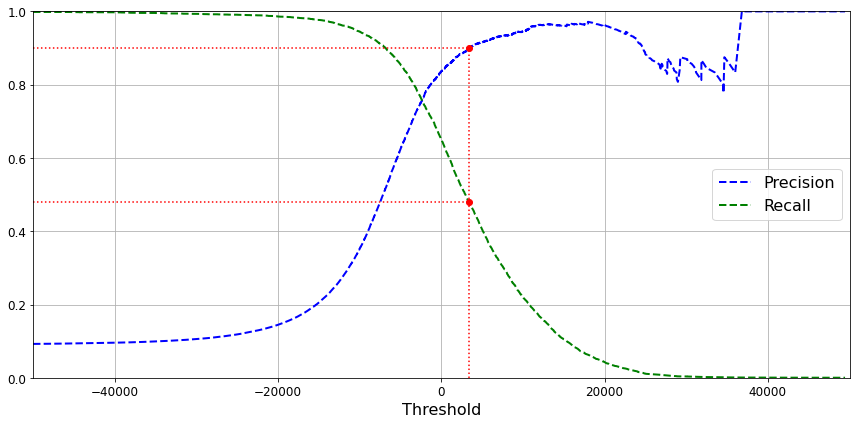

In [53]:
# Plot precision and recall as functions of the threshold
plt.figure(figsize=(12, 6)) 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

recall_90_precision = recalls[np.argmax(precisions >= 0.90)] # recall at precision = 0.9
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # threshold at precision = 0.9

plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:") # x = threshold                
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:") # y = precision                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:") # y = recall
plt.plot([threshold_90_precision], [0.9], "ro") # point at x = threshold, y = precision                                              
plt.plot([threshold_90_precision], [recall_90_precision], "ro") # point at x = threshold, y = recall

save_fig("precision_recall_vs_threshold_plot")    
plt.show()

**Evaluate:**
- Precision sometimes goes down when threshold increases
- Recall can only go down when the threshold increases

Based on the graph, a suitable precision/recall tradeoff is selected easily.

Saving figure precision_vs_recall_plot


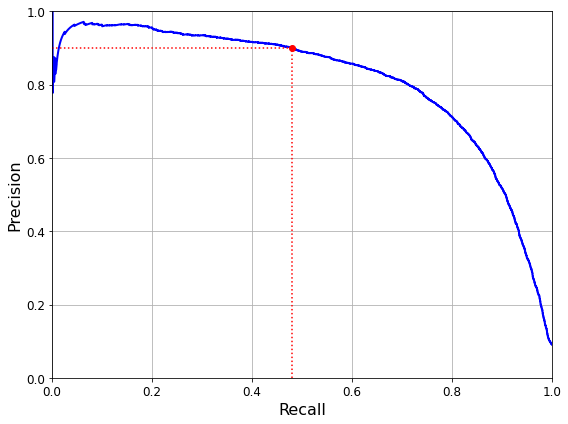

In [54]:
# Plot precision vs recall (another way to show the tradeoff)
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

**Remark:** Suppose to aim for 90% precision.

In [57]:
# Predict on train set using the lowest threshold giving at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [58]:
# Precision of the modified classifier
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [59]:
# Recall of the modified classifier
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

**Remark:** A high-precision classifier is not very useful if its recall is too low!

### The ROC Curve

**Evaluate:** ROC curve plots sensitivity (TPR) vs 1 - specificity (FPR)

In [60]:
# Compute TPR, FPR
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [63]:
# Setup to plot ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, lw=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)

Saving figure roc_curve_plot


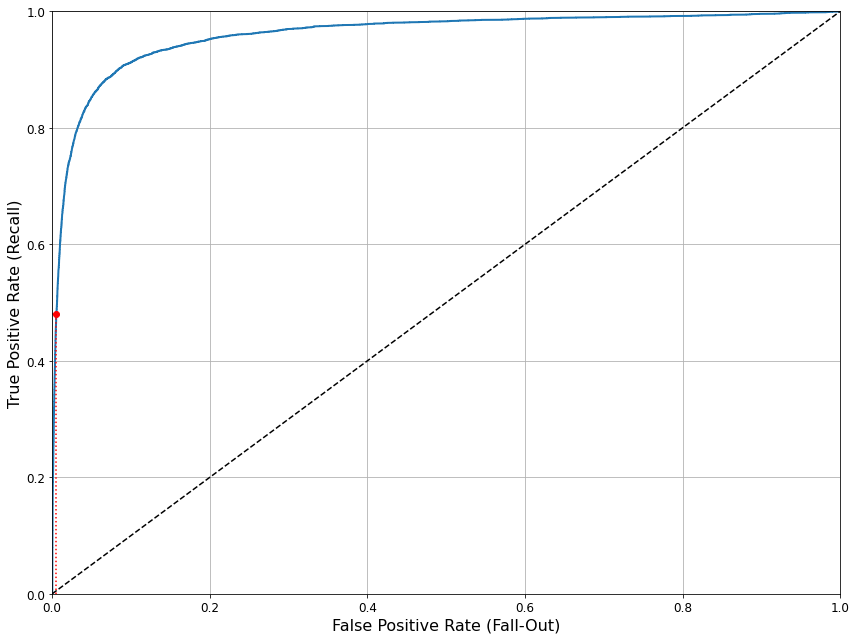

In [64]:
# Plot ROC curve
plt.figure(figsize=(12, 9))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]          
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

**Evaluate:**
- Tradeoff between TPR and FPR
- A good classifier stays as far away from the dashed line as possible (toward the top-left corner)

In [65]:
# Compute ROC AUC
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Remark:** A perfect classifier will have ROC AUC equal to 1. (that is 0.5 for purely random classifier)

**Remark:** PR is prefered whenever either:
- The positive class is rare
- The care is about the FP than FN.

In [66]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

In [67]:
# Invent scores as positive class's probability
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Saving figure roc_curve_comparison_plot


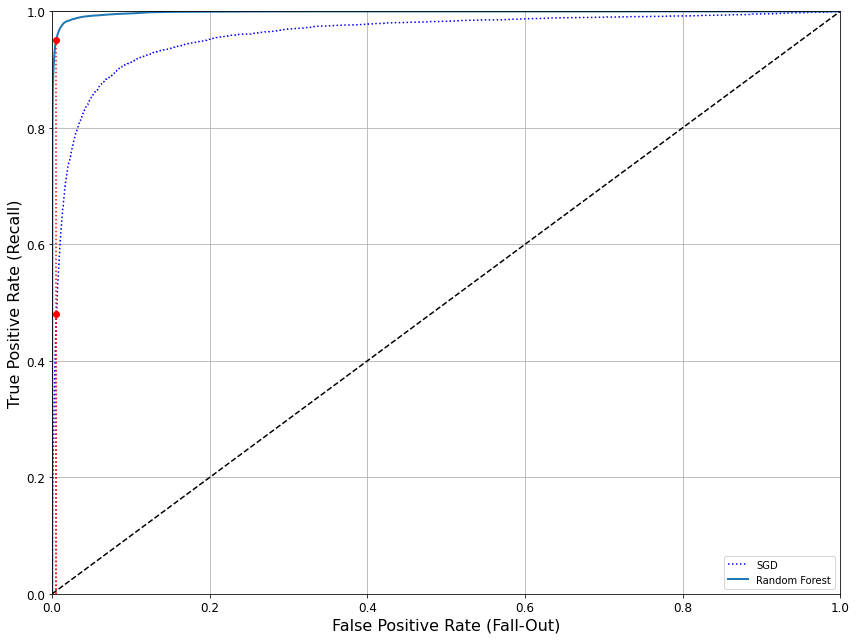

In [74]:
# Plot ROC curve and comparison
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(12, 9)) 
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right")
save_fig("roc_curve_comparison_plot")
plt.show()

**Evaluate:** Intuitively, Random Forest is better than SGD in ROC curve.

In [75]:
# Compute ROC AUC for Random Forest model
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [76]:
# Precision of Random Forest model
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [77]:
# Recall of Random Forest model
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass Classiication